# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

pd.options.display.max_columns = None

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [2]:
# Import data.
loan_data = pd.read_csv('loan_data_clean.csv', index_col = 0)
loan_data.drop(['issue_d'], axis = 1, inplace = True)

In [3]:
loan_data_defaults = loan_data[loan_data['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]
# Here we take only the accounts that were charged-off (written-off).

In [4]:
loan_data_defaults.shape

(41962, 48)

In [5]:
loan_data_defaults.head()

,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,open_acc,pub_rec,revol_util,total_acc,total_rec_prncp,recoveries,mths_since_earliest_cr_line,mths_since_issue_d,good_bad,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_2,sub_grade_3,sub_grade_4,sub_grade_5,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified
1,2500,2500,60,15.27,59.83,0,30000.0,Charged Off,1.00,3.0,0.0,9.4,4.0,456.46,117.08,224.0,72.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
8,5600,5600,60,21.28,152.39,4,40000.0,Charged Off,5.55,11.0,0.0,32.6,13.0,162.02,189.06,164.0,72.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
9,5375,5375,60,12.69,121.45,0,15000.0,Charged Off,18.08,2.0,0.0,36.5,3.0,673.48,269.29,159.0,72.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
12,9000,9000,36,13.49,305.38,0,30000.0,Charged Off,10.08,4.0,0.0,91.7,9.0,1256.14,444.30,164.0,72.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
14,10000,10000,36,10.65,325.74,3,100000.0,Charged Off,7.06,14.0,0.0,55.5,29.0,5433.47,645.10,319.0,72.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0


# Dependent Variables

In [6]:
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']
# We calculate the dependent variable for the LGD model: recovery rate.
# It is the ratio of recoveries and funded amount.

In [7]:
loan_data_defaults['recovery_rate'].describe()
# Shows some descriptive statisics for the values of a column.

count    41962.000000
mean         0.060504
std          0.089409
min          0.000000
25%          0.000000
50%          0.028719
75%          0.113543
max          1.220774
Name: recovery_rate, dtype: float64

In [8]:
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])
# We set recovery rates that are greater than 1 to 1 and recovery rates that are less than 0 to 0.

In [9]:
loan_data_defaults['recovery_rate'].describe()
# Shows some descriptive statisics for the values of a column.

count    41962.000000
mean         0.060457
std          0.088883
min          0.000000
25%          0.000000
50%          0.028719
75%          0.113543
max          1.000000
Name: recovery_rate, dtype: float64

In [10]:
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']
# We calculate the dependent variable for the EAD model: credit conversion factor.
# It is the ratio of the difference of the amount used at the moment of default to the total funded amount.

In [11]:
loan_data_defaults['CCF'].describe()
# Shows some descriptive statisics for the values of a column.

count    41962.000000
mean         0.735334
std          0.200873
min          0.000438
25%          0.630909
50%          0.789307
75%          0.888206
max          1.000000
Name: CCF, dtype: float64

In [12]:
loan_data_defaults.head()

,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,open_acc,pub_rec,revol_util,total_acc,total_rec_prncp,recoveries,mths_since_earliest_cr_line,mths_since_issue_d,good_bad,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_2,sub_grade_3,sub_grade_4,sub_grade_5,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,recovery_rate,CCF
1,2500,2500,60,15.27,59.83,0,30000.0,Charged Off,1.00,3.0,0.0,9.4,4.0,456.46,117.08,224.0,72.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.046832,0.817416
8,5600,5600,60,21.28,152.39,4,40000.0,Charged Off,5.55,11.0,0.0,32.6,13.0,162.02,189.06,164.0,72.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0.033761,0.971068
9,5375,5375,60,12.69,121.45,0,15000.0,Charged Off,18.08,2.0,0.0,36.5,3.0,673.48,269.29,159.0,72.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0.050100,0.874701
12,9000,9000,36,13.49,305.38,0,30000.0,Charged Off,10.08,4.0,0.0,91.7,9.0,1256.14,444.30,164.0,72.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.049367,0.860429
14,10000,10000,36,10.65,325.74,3,100000.0,Charged Off,7.06,14.0,0.0,55.5,29.0,5433.47,645.10,319.0,72.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0.064510,0.456653


In [13]:
loan_data_defaults.to_csv('loan_data_defaults.csv')
# We save the data to a CSV file.

# Explore Dependent Variables

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

(array([2.0466e+04, 1.7790e+03, 3.7730e+03, 1.3480e+03, 2.0800e+03,
        3.2450e+03, 4.5770e+03, 1.6470e+03, 1.1410e+03, 3.9800e+02,
        3.2800e+02, 2.6500e+02, 1.1300e+02, 9.2000e+01, 7.6000e+01,
        6.9000e+01, 5.3000e+01, 6.9000e+01, 5.2000e+01, 2.9000e+01,
        4.5000e+01, 2.6000e+01, 1.6000e+01, 1.5000e+01, 1.9000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.0000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 6.0000e+00, 8.0000e+00, 6.0000e+00,
        8.0000e+00, 6.0000e+00, 1.0000e+01, 9.0000e+00, 8.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 8.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.1000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

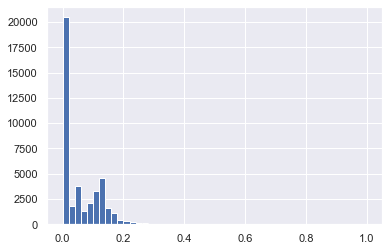

In [15]:
plt.hist(loan_data_defaults['recovery_rate'], bins = 50)
# We plot a histogram of a variable with 50 bins.

(array([   3.,   16.,   15.,   44.,   16.,   13.,   68.,   26.,    7.,
          62.,   64.,   16.,   57.,   87.,   22.,   54.,   82.,   41.,
          47.,  120.,   81.,   68.,  119.,   85.,   86.,  104.,  114.,
         109.,  120.,  118.,  132.,  136.,  154.,  140.,  157.,  173.,
         145.,  183.,  194.,  171.,  199.,  205.,  207.,  206.,  232.,
         259.,  276.,  219.,  300.,  257.,  278.,  291.,  332.,  267.,
         356.,  357.,  375.,  357.,  382.,  406.,  403.,  421.,  430.,
         487.,  464.,  463.,  544.,  550.,  587.,  604.,  710.,  667.,
         606.,  781.,  789.,  760.,  849.,  828.,  888.,  916.,  897.,
        1053.,  906., 1184., 1006., 1035., 1302., 1013., 1326., 1038.,
        1360., 1254.,  926., 1364.,  771., 1266.,  556.,  915.,  330.,
         503.]),
 array([4.3800000e-04, 1.0433620e-02, 2.0429240e-02, 3.0424860e-02,
        4.0420480e-02, 5.0416100e-02, 6.0411720e-02, 7.0407340e-02,
        8.0402960e-02, 9.0398580e-02, 1.0039420e-01, 1.1038982e-01

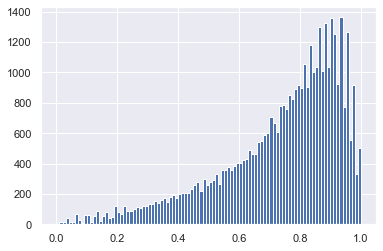

In [16]:
plt.hist(loan_data_defaults['CCF'], bins = 100)
# We plot a histogram of a variable with 100 bins.

In [17]:
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)
# We create a new variable which is 0 if recovery rate is 0 and 1 otherwise.

# EAD Model

### Estimation and Interpretation

As a benchmark model, we have used used a linear regression model. After which we will go on to look at using SVM and neural networks to calculate the best credit conversion factor for our exposure of default. We have used neural networks in our calculations based on recommendations from research papers looking into this subject. However, we have done a very vanilla one layer version of neural network in this project instead of a 3 component layer nueral network using WOE transformed variables cited in the paper. Given more time, computational power, would also explore into applying WOE and information theory into our models as it is supposed to give added macroeconomic depth to our models. Also, similar to LGD, it is suggested that the number of variables used in the model also affects the efficacy of the model, hence also something additional to explore.

source:https://www.researchgate.net/publication/290000490_Modelling_exposure_at_default_and_loss_given_default_Empirical_approaches_and_technical_implementation

In [18]:
# EAD model datasets
X_train, X_test, y_train, y_test = train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF','loan_status'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)
# Takes a set of inputs and a set of targets as arguments. Splits the inputs and the targets into four dataframes:
# Inputs - Train, Inputs - Test, Targets - Train, Targets - Test.

In [19]:
ss=StandardScaler()


#transform and create into a dataframe with column
X_train=ss.fit_transform(X_train)

# Transform.
X_test=ss.transform(X_test)

In [20]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error

In [21]:
reg_ead = LinearRegression()
ridge_model = RidgeCV(alphas=np.linspace(.1, 10, 100))
lasso_model = LassoCV(alphas=np.linspace(.1, 10, 100))


In [22]:
reg_ead.fit(X_train,y_train)
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

LinearRegression()

In [23]:
print("train r2:",reg_ead.score(X_train,y_train))
print("validation r2:",reg_ead.score(X_test,y_test))

train r2: 0.7578802186256149
validation r2: 0.7590909638333669


In [24]:
r_alpha=np.logspace(0,5,100)


# Cross-validate over our list of ridge alphas.

ridge_cv=RidgeCV(alphas=r_alpha,scoring='r2',cv=5)

# Fit model using best ridge alpha!
ridge_cv=ridge_model.fit(X_train,y_train)

In [25]:
ridge_cv.alpha_

2.4000000000000004

In [26]:
print("train r2:",ridge_cv.score(X_train,y_train))
print("validation r2:",ridge_cv.score(X_test,y_test))

train r2: 0.7578797870999772
validation r2: 0.7590980222503207


In [27]:
l_alphas=np.logspace(-3,1,100)
# Cross-validate over our list of Lasso alphas.cv is number of folds
lasso_cv=LassoCV(alphas=l_alphas,cv=5, max_iter=5000)
# Fit model using best ridge alpha!
lasso_cv.fit(X_train,y_train)

LassoCV(alphas=array([1.00000000e-03, 1.09749877e-03, 1.20450354e-03, 1.32194115e-03,
       1.45082878e-03, 1.59228279e-03, 1.74752840e-03, 1.91791026e-03,
       2.10490414e-03, 2.31012970e-03, 2.53536449e-03, 2.78255940e-03,
       3.05385551e-03, 3.35160265e-03, 3.67837977e-03, 4.03701726e-03,
       4.43062146e-03, 4.86260158e-03, 5.33669923e-03, 5.85702082e-03,
       6.42807312e-03, 7.05480231e-0...
       1.17681195e+00, 1.29154967e+00, 1.41747416e+00, 1.55567614e+00,
       1.70735265e+00, 1.87381742e+00, 2.05651231e+00, 2.25701972e+00,
       2.47707636e+00, 2.71858824e+00, 2.98364724e+00, 3.27454916e+00,
       3.59381366e+00, 3.94420606e+00, 4.32876128e+00, 4.75081016e+00,
       5.21400829e+00, 5.72236766e+00, 6.28029144e+00, 6.89261210e+00,
       7.56463328e+00, 8.30217568e+00, 9.11162756e+00, 1.00000000e+01]),
        cv=5, max_iter=5000)

In [28]:
lasso_cv.alphas_

array([1.00000000e+01, 9.11162756e+00, 8.30217568e+00, 7.56463328e+00,
       6.89261210e+00, 6.28029144e+00, 5.72236766e+00, 5.21400829e+00,
       4.75081016e+00, 4.32876128e+00, 3.94420606e+00, 3.59381366e+00,
       3.27454916e+00, 2.98364724e+00, 2.71858824e+00, 2.47707636e+00,
       2.25701972e+00, 2.05651231e+00, 1.87381742e+00, 1.70735265e+00,
       1.55567614e+00, 1.41747416e+00, 1.29154967e+00, 1.17681195e+00,
       1.07226722e+00, 9.77009957e-01, 8.90215085e-01, 8.11130831e-01,
       7.39072203e-01, 6.73415066e-01, 6.13590727e-01, 5.59081018e-01,
       5.09413801e-01, 4.64158883e-01, 4.22924287e-01, 3.85352859e-01,
       3.51119173e-01, 3.19926714e-01, 2.91505306e-01, 2.65608778e-01,
       2.42012826e-01, 2.20513074e-01, 2.00923300e-01, 1.83073828e-01,
       1.66810054e-01, 1.51991108e-01, 1.38488637e-01, 1.26185688e-01,
       1.14975700e-01, 1.04761575e-01, 9.54548457e-02, 8.69749003e-02,
       7.92482898e-02, 7.22080902e-02, 6.57933225e-02, 5.99484250e-02,
      

In [29]:
print("train r2:",lasso_cv.score(X_train,y_train))
print("validation r2:",lasso_cv.score(X_test,y_test))

train r2: 0.7528995201496521
validation r2: 0.7547635631226378


## Support Vector Machines(SVM) with Grid Search CV

In [30]:
from sklearn import svm
from sklearn.svm import SVR

In this implementation, we use the rbf kernel of the SVR model. rbf stands for the radial basis function. It introduces some form of non-linearity to the model since the data in use is non-linear. By this, we mean that the data arrangement follows no specific sequence.

In [31]:
grid = GridSearchCV(

estimator=SVR(kernel='rbf'),
        param_grid={
            'C': np.linspace(0.0001, 2, 10)
        },
        cv=5,  verbose=0, n_jobs=-1)

In [32]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00])})

In [33]:
print("best parameters are: ", grid.best_params_)

best parameters are:  {'C': 2.0}


In [34]:
grid.score(X_train, y_train)

0.9392050872672304

In [35]:
grid.score(X_test, y_test)

0.9033425431322345

## Neural Networks

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [37]:
model = Sequential()
model.add(Dense(32, # How many neurons do you want in your first layer.
                input_shape=(46,),
                activation='relu'))
model.add(Dense(1))

In [40]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [41]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=512)

Epoch 1/10
66/66 [==============================] - 1s 4ms/step - loss: 0.1727 - mae: 0.3012 - val_loss: 0.0699 - val_mae: 0.2048
Epoch 2/10
66/66 [==============================] - 0s 2ms/step - loss: 0.0530 - mae: 0.1760 - val_loss: 0.0397 - val_mae: 0.1531
Epoch 3/10
66/66 [==============================] - 0s 3ms/step - loss: 0.0326 - mae: 0.1366 - val_loss: 0.0267 - val_mae: 0.1240
Epoch 4/10
66/66 [==============================] - 0s 2ms/step - loss: 0.0230 - mae: 0.1140 - val_loss: 0.0202 - val_mae: 0.1064
Epoch 5/10
66/66 [==============================] - 0s 2ms/step - loss: 0.0179 - mae: 0.0996 - val_loss: 0.0163 - val_mae: 0.0945
Epoch 6/10
66/66 [==============================] - 0s 2ms/step - loss: 0.0146 - mae: 0.0893 - val_loss: 0.0135 - val_mae: 0.0858
Epoch 7/10
66/66 [==============================] - 0s 1ms/step - loss: 0.0124 - mae: 0.0821 - val_loss: 0.0119 - val_mae: 0.0796
Epoch 8/10
66/66 [==============================] - 0s 2ms/step - loss: 0.0109 - mae: 0.07

In [42]:
model.predict(X_test)

array([[0.60626376],
       [0.81451803],
       [0.8016593 ],
       ...,
       [0.9896458 ],
       [0.59975004],
       [0.66020477]], dtype=float32)

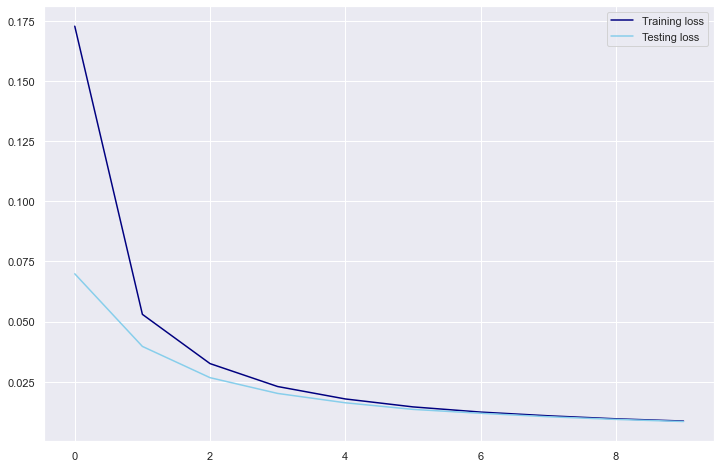

In [43]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

Out of the few models we have used above to model EAD, we can see that utilising Neural networks have the best performance  where loss and mean error is  minimal. SVM is also a good model as we can see a score of 0.90~ for both the training set and testing set. This shows no overfit and the scores are significantly higher than that of linear regression. This model will be the best to use to calculate exposure at default(i.e total value a bank is exposed to when a loan defaults). With more time and computational power, would look to tune more hypermaraters for SVM such as epsilon and adding more layers to my neural netowrk.